## TEMA 2.2: Recommender Systems.

In this notebook we will see how to create a recommender system. To this end we will explore different properties of recommender systems, develope and evaluate a collaborative recommender system.

This notebook corresponds to Chapter 9 of the book **Introduction to Data Science, A Python Approch to Concepts, Techniques and Applications**, Laura Igual and Santi Seguí, Springer 2017


In [1]:
import matplotlib.pylab as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

%matplotlib inline 
plt.style.use('seaborn-whitegrid')
plt.rc('text', usetex=True)
plt.rc('font', family='times')
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plt.rc('font', size=12) 

## Data description

We will work with the well known MovieLens dataset (http://grouplens.org/datasets/movielens/). This dataset was initially constructed to support participants in the Netflix Prize. Today, we can find several versions of this dataset with different amout of data, from 100k samples version to 20m sample version.
Although performance on bigger dataset is expected to be better, we will work with the smallest dataset: MovieLens *100K Dataset (ml-100k-zip)*. Working with this lite version has the benefit of less computational costs, while we will also get the skills required on user-based recommender systems.

With a unix machine the dataset can be downloaded with the following code:

In [2]:
#!wget http://files.grouplens.org/datasets/movielens/ml-1m.zip

#!unzip 'data/ml-1m.zip' -d "data/"

Once you have unzipped the file into a directory, you can create a DataFrame with the following code:

In [3]:
import pandas as pd
import numpy as np
import math
import matplotlib.pylab as plt
from math import isnan

# Load Data set
u_cols = ['user_id', 'age_desc', 'sex', 'occupation', 'zip_code']
#users = pd.read_csv('data/ml-100k/u.user', sep='|', names=u_cols)

r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
#ratings = pd.read_csv('data/ml-100k/u.data', sep='\t', names=r_cols)

# the movies file contains columns indicating the movie's genres
# let's only load the first three columns of the file with usecols
m_cols = ['movie_id', 'title', 'release_date','genre']
#movies = pd.read_csv('data/ml-100k/u.item', encoding = "ISO-8859-1", sep='|', names=m_cols, usecols=range(4))

ratings = pd.read_csv('data/ratings.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'movie_id', 'rating'])

# Reading users file
users = pd.read_csv('data/users.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])

# Reading movies file
movies = pd.read_csv('data/movies.csv', sep='\t', encoding='latin-1', usecols=['movie_id','title','genres'])

# Construcció del DataFrame
data = pd.merge(pd.merge(ratings, users), movies)
data = data[['user_id', 'gender','age_desc','title', 'movie_id','rating','genres']]


print ("The DB has "+ str(data.shape[0]) +" ratings")
print ("The DB has ", data.user_id.nunique()," users")
print ("The DB has ", data.movie_id.nunique(), " movies")
print (data[:10])

The DB has 1000209 ratings
The DB has  6040  users
The DB has  3706  movies
   user_id gender  age_desc                                   title  movie_id  \
0        1      F  Under 18  One Flew Over the Cuckoo's Nest (1975)      1193   
1        2      M       56+  One Flew Over the Cuckoo's Nest (1975)      1193   
2       12      M     25-34  One Flew Over the Cuckoo's Nest (1975)      1193   
3       15      M     25-34  One Flew Over the Cuckoo's Nest (1975)      1193   
4       17      M     50-55  One Flew Over the Cuckoo's Nest (1975)      1193   
5       18      F     18-24  One Flew Over the Cuckoo's Nest (1975)      1193   
6       19      M  Under 18  One Flew Over the Cuckoo's Nest (1975)      1193   
7       24      F     25-34  One Flew Over the Cuckoo's Nest (1975)      1193   
8       28      F     25-34  One Flew Over the Cuckoo's Nest (1975)      1193   
9       33      M     45-49  One Flew Over the Cuckoo's Nest (1975)      1193   

   rating genres  
0       5  Dr

If you explore the dataset in detail, you will see that it  consists of:
<ul>
<li>100,000 ratings from 943 users of 1682 movies. Ratings are from 1 to 5.</li>
<li>Each user has rated at least 20 movies.</li>
<li>Simple demographic info for the users (age, gender, occupation, zip)</li>
</ul>

In [4]:
print ('First votes of user 1: \n', data[data.user_id==1].head(10))
print ('\n Mean voting of user 1: \n',  data.rating[data['user_id']==1].mean())
print ('\n Mean voting for the movie "Seven": \n', data.rating[data.title=="Seven (Se7en) (1995)"].mean())
most_rated = data.groupby('title').size().sort_values(ascending=False).head()
print ('\n Most voted movies: \n', most_rated)
highest_score = data.groupby('title').rating.mean().sort_values(ascending=False).head()
print ('\n Best valued movies: \n',  highest_score)
size = data.groupby('title').size()
mean_score = data.groupby('title').rating.mean()
print ('\n Movies with more than 10 votes ',  mean_score[size>10].sort_values(ascending=False).head(10))

First votes of user 1: 
        user_id gender  age_desc                                   title  \
0            1      F  Under 18  One Flew Over the Cuckoo's Nest (1975)   
1725         1      F  Under 18        James and the Giant Peach (1996)   
2250         1      F  Under 18                     My Fair Lady (1964)   
2886         1      F  Under 18                  Erin Brockovich (2000)   
4201         1      F  Under 18                    Bug's Life, A (1998)   
5904         1      F  Under 18              Princess Bride, The (1987)   
8222         1      F  Under 18                          Ben-Hur (1959)   
8926         1      F  Under 18               Christmas Story, A (1983)   
10278        1      F  Under 18  Snow White and the Seven Dwarfs (1937)   
11041        1      F  Under 18                Wizard of Oz, The (1939)   

       movie_id  rating                              genres  
0          1193       5                               Drama  
1725        661       3  

In [5]:
# Import new libraries: pip install wordcloud 
%matplotlib inline
import wordcloud
from wordcloud import WordCloud, STOPWORDS

# Create a wordcloud of the movie titles
movies['title'] = movies['title'].fillna("").astype('str')
title_corpus = ' '.join(movies['title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

In [6]:
#How many movies are voted per user
rated_movies = data.groupby('user_id').size()
rated_movies.hist(bins=20)

In [7]:
# Make a census of the genre keywords
genre_labels = set()
for s in movies['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

# Function that counts the number of times each of the genre keywords appear
def count_word(dataset, ref_col, census):
    keyword_count = dict()
    for s in census: 
        keyword_count[s] = 0
    for census_keywords in dataset[ref_col].str.split('|'):        
        if type(census_keywords) == float and pd.isnull(census_keywords): 
            continue        
        for s in [s for s in census_keywords if s in census]: 
            if pd.notnull(s): 
                keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

# Calling this function gives access to a list of genre keywords which are sorted by decreasing frequency
keyword_occurences, dum = count_word(movies, 'genres', genre_labels)
keyword_occurences[:5]

[['Drama', 1603],
 ['Comedy', 1200],
 ['Action', 503],
 ['Thriller', 492],
 ['Romance', 471]]

In [8]:
print(users.head())

   user_id gender zipcode  age_desc              occ_desc
0        1      F   48067  Under 18          K-12 student
1        2      M   70072       56+         self-employed
2        3      M   55117     25-34             scientist
3        4      M   02460     45-49  executive/managerial
4        5      M   55455     25-34                writer


## Building a Collaborative Filtering (CF) for Movilens dataset
The idea behind any recommender system is to suggest or recommend items that are likely to be of interest to the user. If we think on the movielens dataset and a movie recommender system, the goal will consist on recommend those useen movies by a given "user" that are more likely to be intersting to him or her. So, the problem can be taken by predicting the ratings for the unseen movies of the given "user" and recommend those with the highest predicted rating.

<br>The following table ilustrates the problem. This toy dataset consists on 4 users and 4 items.  Users 1, 2 and 3 have seen all the movies while user 3 has only seen Superman and Star Wars. So, the problem consist on prediction which movie, Matrix or Spiderman, will be more likely for the user 4.
<table style="width:60%">
  <tr>
    <td></td>
    <td>Superman</td> 
    <td>Star Wars 1</td>
    <td>Matrix</td>
    <td>Spiderman</td>
    
  </tr>
  <tr>
    <td>user1</td>
    <td>3</td> 
    <td>3.5</td>
    <td>4.5</td>
    <td>3</td>
  </tr>
  <tr>
    <td>user2</td>
    <td>3.5</td> 
    <td>4</td>
    <td>5</td>
    <td>5</td>
  </tr>
  <tr>
    <td>user3</td>
    <td>3</td> 
    <td>4</td>
    <td>4.5</td>
    <td>3</td>
  </tr>
  <tr>
    <td>user4</td>
    <td>3.5</td> 
    <td>5</td>
    <td><font color="red"><b>¿?</b></font></td>
    <td><font color="red"><b>¿?</b></font></td>
  </tr>
</table>
<br><br><br><br>


In order to create a collaborative recommender system we will have to define: 1) a prediction function, 2) a user-similarity function and 3) an evaluation function.

### Prediction function:
The prediction function behind the CF will be based on the movie ratings from similar users.
So, in order to recommend a movie, $p$, from a set of movies, $P$, to a given user, $a$, we first need to see the set of users, $B$, who have already seen $p$. Then, we need to see the taste similarity between these users in $B$ and user $a$. The most simple prediction function for a user $a$ and movie $p$ can be defined as follows:

$$pred(a,p) = \frac{\sum_{b \in B}{sim(a,b)*(r_{b,p})}}{\sum_{b \in B}{sim(a,b)}}$$

where $sim(a,b)$ is the similarity between user $a$ and user $b$,  $B$ is the set of users in the dataset that have already seen $p$ and $r_{b,p}$ is the rating of $p$ by $b$.

<h3>Users similarity</h3>
The computation of the similarity between items is one of the most critical steps in the CF algorithms. The basic idea behind the similarity computation between two users $a$ and $b$, is that we can first isolate the set $P$ of items rated by both users, and then apply a similarity computation technique to determine the similarity.

The set of *common_movies* can be obtained with the following code:

In [9]:
# dataframe with the data from user 1
data_user_1 = data[data.user_id==1]
# dataframe with the data from user 2
data_user_2 = data[data.user_id==6]
# We first compute the set of common movies
common_movies = set(data_user_1.movie_id).intersection(data_user_2.movie_id)
print ("\nNumber of common movies",len(common_movies),'\n')

# creat the subdataframe with only with the common movies
mask = (data_user_1.movie_id.isin(common_movies))
data_user_1 = data_user_1[mask]
print (data_user_1[['title','rating']].head())

mask = (data_user_2.movie_id.isin(common_movies))
data_user_2 = data_user_2[mask]
print (data_user_2[['title','rating']].head())


Number of common movies 10 

                             title  rating
2250           My Fair Lady (1964)       3
2886        Erin Brockovich (2000)       4
12759  Beauty and the Beast (1991)       5
15859   Sound of Music, The (1965)       5
21674         Pleasantville (1998)       3
                             title  rating
2251           My Fair Lady (1964)       5
2888        Erin Brockovich (2000)       5
12760  Beauty and the Beast (1991)       4
15860   Sound of Music, The (1965)       5
21676         Pleasantville (1998)       3


Once the set of ratings for all movies common to the two users has been obtained, we can compute the user similarity. These are some of the most common similarity functions used in CF methods: 

   <ul>
    <li>Euclidean distance</li>
    $$sim(a,b) = \sqrt{\sum_{p \in P}{(r_{a,p} - r_{b,p})^2}}$$
    <br>
    <li>Pearson Correlation</li>
    $$sim(a,b) = \frac{\sum_{p\in P} (r_{a,p}-\bar{r_a})(r_{b,p}-\bar{r_b})}{\sqrt{\sum_{p \in P}(r_{a,p}-\bar{r_a})²}\sqrt{\sum_{p \in P}(r_{b,p}-\bar{r_b})²}}$$
    <br>
    <li>Cosine distance</li>
    $$ sim(a,b) = \frac{\vec{a}· \vec{b}}{|\vec{a}| * |\vec{b}|}$$
    <br>
    </ul>
  
<br>
Where: 

* $sim(a,b)$ is the similarity between user "a" and user "b"
* $P$ is the set of common rated movies by user "a" and "b"
* $r_{a,p}$ is the rating of movie "p" by user "a"
* $\bar{r_a}$ is the mean rating given by user "a"

<br>

<h4>Some issues to take into accout</h4>
<ul>
<li>Pearson Correlation used to work better than euclidean distance since it is based more on the ranking than on the values.</li>
<li>Cosine distance is usually used when our data is binary/unary, i.e. like vs. not like  or buy vs. not buy.</li>
<li>What happens if two users have very few items in common?</li>
</ul>



Let's define a function to compute the users similarity 

In [10]:
from scipy.stats import pearsonr
from scipy.spatial.distance import euclidean
import seaborn as sns;

# Returns a distance-based similarity score for person1 and person2
def SimEuclid(DataFrame,User1,User2,min_common_items=1):
    # GET MOVIES OF USER1
    movies_user1=DataFrame[DataFrame['user_id'] ==User1 ]
    # GET MOVIES OF USER2
    movies_user2=DataFrame[DataFrame['user_id'] ==User2 ]
    
    # FIND SHARED FILMS
    rep=pd.merge(movies_user1 ,movies_user2,on='movie_id')    
    if len(rep)==0:
        return 0
    if(len(rep)<min_common_items):
        return 0
    #return distEuclid(rep['rating_x'],rep['rating_y']) 
    return 1.0/(1.0+euclidean(rep['rating_x'],rep['rating_y'])) 

# Returns a pearsonCorrealation-based similarity score for person1 and person2
def SimPearson(DataFrame,User1,User2,min_common_items=1):
    # GET MOVIES OF USER1
    movies_user1=DataFrame[DataFrame['user_id'] ==User1 ]
    # GET MOVIES OF USER2
    movies_user2=DataFrame[DataFrame['user_id'] ==User2 ]
    
    # FIND SHARED FILMS
    rep=pd.merge(movies_user1 ,movies_user2,on='movie_id')
    if len(rep)==0:
        return 0    
    if(len(rep)<min_common_items):
        return 0    
    res=pearsonr(rep['rating_x'],rep['rating_y'])[0]
    if(isnan(res)):
        return 0
    return res


Let's see how similars are user 1 with 732 and 1 with 495

In [11]:
person1 = 1
print ("-----")
person2 = 672
print ("Euclidean Similarity users", person1, "and", person2, ': %.5f' % SimEuclid(data,person1,person2))
print ("Pearson Similarity users", person1, "and", person2, ': %.5f' % SimPearson(data,person1,person2))
print ("-----")
person2 = 495
print ("Euclidean Similarity users", person1, "and", person2, ': %.5f' % SimEuclid(data,person1,person2))
print ("Pearson Similarity users", person1, "and", person2, ': %.5f' % SimPearson(data,person1,person2))
print ("-----")

-----
Euclidean Similarity users 1 and 672 : 0.50000
Pearson Similarity users 1 and 672 : 0.97590
-----
Euclidean Similarity users 1 and 495 : 0.20000
Pearson Similarity users 1 and 495 : -0.93541
-----


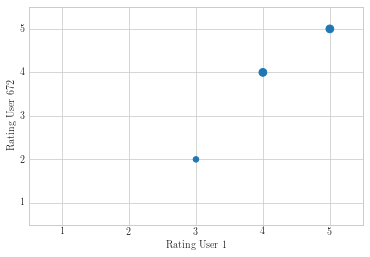

In [12]:
movies_user1=data[data['user_id'] ==1 ][['user_id','movie_id','rating']]
movies_user2=data[data['user_id'] ==672 ][['user_id','movie_id','rating']]
    
# FIND SHARED FILMS
rep=pd.merge(movies_user1 ,movies_user2,on='movie_id')
x= rep.rating_x + np.random.normal(loc=0.0, scale=0.1,size=len(rep.rating_x))
y= rep.rating_y +np.random.normal(loc=0.0, scale=0.1,size=len(rep.rating_y))
    
a=rep.groupby(['rating_x', 'rating_y']).size()
x=[]
y=[]
s=[]
for item,b in a.iteritems():
    x.append(item[0])
    y.append(item[1])
    s.append(b*30)

fig = plt.figure(figsize=(6,4))
plt.scatter(x,y, s=s)
plt.xlabel('Rating User 1')
plt.ylabel('Rating User '+str(672))
plt.axis([0.5,5.5,0.5,5.5])
plt.savefig("data/corre1672.png",dpi= 300, bbox_inches='tight')
plt.show()

And, with user 495:

In [13]:
movies_user1=data[data['user_id'] ==1 ][['user_id','movie_id','rating']]
movies_user2=data[data['user_id'] ==991 ][['user_id','movie_id','rating']]
    
# FIND SHARED FILMS
rep=pd.merge(movies_user1 ,movies_user2,on='movie_id')
x= rep.rating_x + np.random.normal(loc=0.0, scale=0.1,size=len(rep.rating_x))
y= rep.rating_y +np.random.normal(loc=0.0, scale=0.1,size=len(rep.rating_y))
    
a=rep.groupby(['rating_x', 'rating_y']).size()
x=[]
y=[]
s=[]

fig = plt.figure(figsize=(6,4))
for item,b in a.iteritems():
    x.append(item[0])
    y.append(item[1])
    s.append(b*30)
plt.scatter(x,y, s=s)
plt.xlabel('Rating User 1')
plt.ylabel('Rating User '+str(991))
plt.axis([0.5,5.5,0.5,5.5])
plt.savefig("data/corre1991.png",dpi= 300, bbox_inches='tight')
plt.show()


## Evaluation: performance criterion

In order to validate the system, we will divide the dataset into two different sets: one called $X\_train$ containing $80\%$ of the data from each user; and another called $X\_test$, with the remaining $20\%$ of the data from each user. In the following code we create a function

In [14]:
def assign_to_set(df):
    sampled_ids = np.random.choice(df.index,
                                   size=np.int64(np.ceil(df.index.size * 0.2)),
                                   replace=False)
    df.ix[sampled_ids, 'for_testing'] = True
    return df

data['for_testing'] = False
grouped = data.groupby('user_id', group_keys=False).apply(assign_to_set)
data_train = data[grouped.for_testing == False]
data_test = data[grouped.for_testing == True]

print ("Training DB has "+ str(data_train.shape[0]) +" ratings")
print ("Test DB has "+ str(data_test.shape[0]) +" ratings")
print ("The DB has ", data.movie_id.nunique(), " movies")


Training DB has 797758 ratings
Test DB has 202451 ratings
The DB has  3706  movies



Once the data is divided in these sets, we can build a model with the  \emph{training set} and evaluate its performance using the \emph{test set}. In our case, the evaluation will be performed using the standard RMSE:

In [15]:
def compute_rmse(y_pred, y_true):
    """ Compute Root Mean Squared Error. """
    return np.sqrt(np.mean(np.power(y_pred - y_true, 2)))

## Recommender System 
We can define our recommender system with a Python class. This class consists of a constructor and two methods: fit and predict.

In [16]:
class CollaborativeFiltering:
    """ Collaborative filtering using a custom sim(u,u'). """
    numberusers = 20
    
    def __init__(self,DataFrame, similarity=SimPearson):
        """ Constructor """
        self.sim_method=similarity# Gets recommendations for a person by using a weighted average
        self.df=DataFrame
        self.sim = pd.DataFrame(np.sum([0]),columns=data_train.user_id.unique(), index=data_train.user_id.unique())

    def learn(self):
        """ Prepare data structures for estimation. Similarity matrix for users """
        allUsers=set(self.df['user_id'])
        self.sim = {}
        for person1 in list(allUsers)[:self.numberusers]:
            self.sim.setdefault(person1, {})
            a=data_train[data_train['user_id']==person1][['movie_id']]
            data_reduced=pd.merge(data_train,a,on='movie_id')
            for person2 in  list(allUsers)[:self.numberusers]:
                # no es comparem am nosalres mateixos
                if person1==person2: continue
                self.sim.setdefault(person2, {})
                if(person1 in self.sim[person2]):continue # since is a simetric matrix
                sim=self.sim_method(data_reduced,person1,person2)
                if(sim<0):
                    self.sim[person1][person2]=0
                    self.sim[person2][person1]=0
                else:
                    self.sim[person1][person2]=sim
                    self.sim[person2][person1]=sim
                
    def estimate(self, user_id, movie_id):
        totals={}
        movie_users=self.df[self.df['movie_id'] ==movie_id]
        rating_num=0.0
        rating_den=0.0
        allUsers=set(movie_users['user_id'])
        for other in list(allUsers)[:self.numberusers]:
            if user_id==other: continue
            if other>self.numberusers: continue
            rating_num += self.sim[user_id][other] * float(movie_users[movie_users['user_id']==other]['rating'])
            rating_den += self.sim[user_id][other]
        if rating_den==0: 
            if self.df.rating[self.df['movie_id']==movie_id].mean()>0:
                # return the mean movie rating if there is no similar for the computation
                return self.df.rating[self.df['movie_id']==movie_id].mean()
            else:
                # else return mean user rating 
                return self.df.rating[self.df['user_id']==user_id].mean()
        return rating_num/rating_den



In [17]:
reco = CollaborativeFiltering(data_train)

reco.learn()

reco.estimate(user_id=2,movie_id=1)

4.45151446531252

Modifying the Recomender System using as a prediction function the following equation:
$$pred(a,p) = \bar{r_a} + \frac{\sum_{b \in N}{sim(a,b)*(r_{b,p}-\bar{r_b})}}{\sum_{b \in N}{sim(a,b)}}$$

In [18]:
class CollaborativeFiltering2:
    """ Collaborative filtering using a custom sim(u,u'). """
    numberusers = 20
    
    def __init__(self,DataFrame, similarity=SimPearson):
        """ Constructor """
        self.sim_method=similarity# Gets recommendations for a person by using a weighted average
        self.df=DataFrame
        self.sim = pd.DataFrame(np.sum([0]),columns=data_train.user_id.unique(), index=data_train.user_id.unique())

    def learn(self):
        """ Prepare data structures for estimation. Similarity matrix for users """
        allUsers=set(self.df['user_id'])
        self.sim = {}
        for person1 in list(allUsers)[:self.numberusers]:
            self.sim.setdefault(person1, {})
            a=data_train[data_train['user_id']==person1][['movie_id']]
            data_reduced=pd.merge(data_train,a,on='movie_id')
            for person2 in list(allUsers)[:self.numberusers]:
                # no es comparem am nosalres mateixos
                if person1==person2: continue
                self.sim.setdefault(person2, {})
                if(person1 in self.sim[person2]):continue # since is a simetric matrix
                sim=self.sim_method(data_reduced,person1,person2)
                #print person1,person2,sim
                if(sim<0):
                    self.sim[person1][person2]=0
                    self.sim[person2][person1]=0
                else:
                    self.sim[person1][person2]=sim
                    self.sim[person2][person1]=sim
                
        self.mean_ratings=mean_rating=data_train[['user_id','movie_id','rating']].groupby('user_id')['rating'].mean()
                
                
    def estimate(self, user_id, movie_id):
        
        totals={}
        movie_users=self.df[self.df['movie_id'] ==movie_id]
        rating_num=0.0
        rating_den=0.0
        allUsers=set(movie_users['user_id'])
        for other in list(allUsers)[:self.numberusers]:
            if user_id==other: continue 
            if other>self.numberusers: continue
            rating_num += self.sim[user_id][other] * (float(movie_users[movie_users['user_id']==other]['rating']-self.mean_ratings[other]))
            rating_den += self.sim[user_id][other]
        if rating_den==0: 
            if self.df.rating[self.df['movie_id']==movie_id].mean()>0:
                # return the mean movie rating if there is no similar for the computation
                return self.df.rating[self.df['movie_id']==movie_id].mean()
            else:
                # else return mean user rating 
                return self.df.rating[self.df['user_id']==user_id].mean()
        return self.mean_ratings[user_id]+rating_num/rating_den



In [19]:
reco2 = CollaborativeFiltering2(data_train)
reco2.learn()
reco2.estimate(user_id=2,movie_id=1)

4.333370574973719